# A Differentiable Approximation for Entropies 

### 1. Entropy and Information Content in Neural Networks

Neural networks are just functions. Admittedly, highly parameterized functions, but yes - just functions: $y=f(x)$. Here, $x$ is some input - like e.g. an image - and $y$ is the output. Once the network is sufficiently trained, we dare to interpret the output as an estimation for the probability of that image to represent a particular digit, given the pixel intensities of that image. Even humans would agree that the following digit may be interpreted in different ways. You may in fact give it a 10% probability to be a three. Typically, we even dare to interpret the highest of probabilities as the *prediction*, like "That image in fact *is* a digit 5".

![3_or_5](./5.png)

Training a neural network means exposing the network to a sufficiently large sample (the training set) from a probability distribution of pixel sets (images) and guide it (via Gradient Descent) to reproduce (infer) the digit that was meant by the hand-writing (the prior). In information theory, we call *"writing the digit down and making a photo of it"* a noisy encoding. The information about the original intent is still encoded in the image, but sometimes there's room for misinterpretations. Now, as the pixel distribution is passed through the neural network, at each layer we create a new a new distribution - this time of activations - from the original input. It would be interesting to understand how the information content changes from layer to layer. And that's where Entropy enters the game. 

Aurelion Geron recorded an amazingly easy-to-grasp youtube clip called [Entropy, Cross-Entropy, & KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8). If you're not already familiar with the concepts of entropy, I highly recommend it. Aurelion's warm-hearted french accent makes information theory even sound somewhat sexy. Of course, there is a plethora of more serious books out there. My personal favourite is Bavaud, Chappelier, Kohlas' comprehensive introductory text - a whopping 300 pages of math available as pdf:  [An Introduction to Information Theory and Applications](http://www.fon.hum.uva.nl/rob/Courses/InformationInSpeech/CDROM/Literature/LOTwinterschool2006/diuf.unifr.ch/tcs/courses/it04-05/script/information-theory.pdf)

Here's a summary of things you should know and understand to some degree:

##### Entropy 

$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

##### Conditional entropy 

$$ H(Y \big| X) := -\sum_{x \in \mathcal{X}} p(x) H(Y\big|X=x) = -\sum_{x \in \mathcal{X}} p(x) \sum_{y\in \mathcal{Y}} p(y|x) \cdot \log p(y|x) = -\sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

##### Joint Entropy 

$$ H(Y, X) := -\sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log p(x,y)$$

##### Mutual information

$$ I(X;Y) := \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y)log(\frac{p(x,y)}{p(x)p(y)}) $$

##### Some useful properties 
$$ H(X,Y) \leq H(X)+H(Y)$$

$$ H(Y|X) = 0 \iff  \text{Y is completely determined by X} $$ 

$$ H(Y|X) = H(Y) \iff \text{X and Y are independent}$$

$$ H(Y|X) = H(Y,X) - H(X) $$

$$ I(X;Y) = H(X) + H(Y) - H(X,Y) $$

$$ I(X;Y) = H(Y) - H(Y|X) $$

Let's start with entropy. The entropy of a distribution is the average amount of information that we get when a sample is revealed. The weather in the Sahara has a low entropy, because if you tell me it's sunny there, I could have guessed that. Quite the opposite in e.g. Switzerland. Weather forecasts are always very appreciated, because the weather is changing so much. Same with digits: If you tell me that the center pixel of an image depicting the digit zero is white, that's not surprising at all. But if I didn't know what digit is displayed, that information would be very valuable, because it may be a good hint that the digit is a zero. The conditional entropy of the center pixel distribution, given $x=0$ is low. The overall entropy of the center pixel is higher. 

### 2. Example: MNIST's Center Pixel Statistics
Why not leave theory for now and prove what I said: Let's calculate the center pixel's entropy on a large training batch. And then compare that to the conditional entropy, i.e. the entropy on the subset of digits zero. 

We'll be using the Tensorflow 1.6.0 release candidate:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import dataset # Please have a look at dataset.py in this repo to understand how we get to the data
tf.__version__

'1.7.0'

In [2]:
sess = tf.InteractiveSession()

Note that we're using the recommended tf.data.Dataset API here

It's always recommended to visualize and verify the quality of the input data. 

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

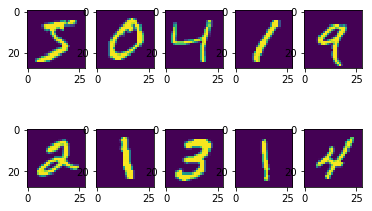

In [3]:
FLAGS=lambda: None
FLAGS.data_dir='data/digits'

training_set = dataset.training_dataset(FLAGS.data_dir)
samples = training_set.batch(10).make_one_shot_iterator().get_next()
samples = sess.run(samples)
f, arr = plt.subplots(2,5)
for row in (0, 1):
    for col in range(5):
        i = 5 * row + col
        img = samples[0][i].reshape([28,28])
        arr[row, col].imshow(img)
samples[1][:10]

So, that's good. Let's take the zeros within the first 10'000 images (There are 1001 of those). Enjoy the beautiful functional interface of the datasets!

1001

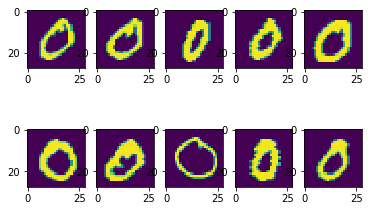

In [4]:
FLAGS=lambda: None
FLAGS.data_dir='data/digits'

training_set = dataset.training_dataset(FLAGS.data_dir)
samples = training_set.repeat().batch(10000).make_one_shot_iterator().get_next()
_samples = sess.run(samples)

# Functional interfaces: Read from bottom to top: zip - then filter - then map
zeros = list(map( lambda r: r[0],          # take the image, drop the class, it's zero anyway!
    filter(lambda r: r[1] == 0,            # filter zero class
           zip(_samples[0],_samples[1])))) # zip images and classes

f, arr = plt.subplots(2,5)
for row in (0, 1):
    for col in range(5):
        i = 5 * row + col
        img = np.reshape(zeros[i], [28,28])
        arr[row, col].imshow(img)
len(zeros)

Now, we'll extract the center pixel No. 406 and observe the distribution of it's value within the zeros compared to the entire batch of 10'000 images

(array([961.,   6.,   7.,   3.,   7.,   1.,   4.,   2.,   2.,   8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

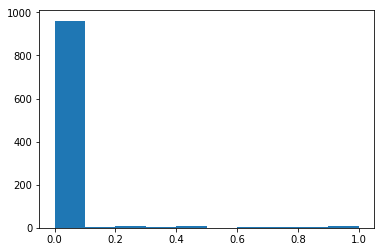

In [5]:
# An image has 28x28=784 pixels, hence 784/2 + 14 = 406 is the center pixel (Ok, ok, it's one of the four center pixels!)
CENTER_POS = 406

centers_0  = list(map(lambda img: img[CENTER_POS], zeros))
centers_all  = list(map(lambda img: img[CENTER_POS], _samples[0]))
plt.hist(centers_0, bins=10)

As promised, apart from a few exceptions, almost all pixels are zero or very close to zero. Let's see the distribution of all the center pixel values:

(array([3782.,  261.,  286.,  259.,  260.,  250.,  304.,  341.,  360.,
        3897.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

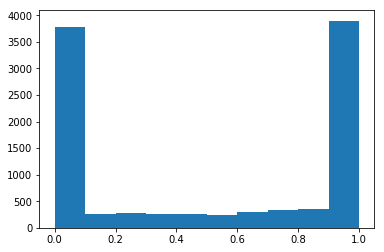

In [6]:
plt.hist(centers_all, bins=10)

As opposed to the above, the distribution within the entire batch of 10'000 is less predictable, i.e. it has a higher entropy.

To compute the entropy of the distribution, we take the bin counts that are automatically calculated for us by the pyplot package (See output of the previous cell). It would be nice to have a little function that does the jobs for us, woudln't it? Well, we save that for later when we introduce a function that indeed does it and also comes with the additional property of being differentiable.

In [7]:
probs_all = np.array([3782, 261, 286, 259, 260, 250, 304, 341, 360, 3897]) / 10000
ln_probs_all = np.log(probs_all)
entropy_all = -np.sum(probs_all * ln_probs_all)

probs_0 = np.array([961, 6, 7, 3, 7, 1, 4, 2, 2, 8]) / 1001
ln_probs_0 = np.log(probs_0)
entropy_0 = -np.sum(probs_0 * ln_probs_0)

entropy_0, entropy_all

(0.24904864416161798, 1.5546047214294172)

You can now see that the entropy of the entire batch of 10'000 is much higher than the entropy of the distribution given that the digit is known to be 0. But now, how would we calculate the entropy in the absence of pyplot? You could think of some function that looks at each value in a distribution and select a partition (or bin) based on that value. Eventually it would count the number of examples in each bin. This procedure does the job but it isn't differentiable

### 3. Interlude: Differentiable Partitioning

We have seen how we can calculate the total entropy and the conditional entropy with regards to the labels of a mini-batch of image samples with the help of simple statistics based on binned distributions. In order to use the entropy as a cost function within the concept of gradient-based optimization later on, we need a differentiable approximation of the entropy terms. That turns out to be an easy exercise. 

Remember the sigmoid function?
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Let's use two of these to create a more interesting kind of *partitioning* function:

$ f(x) = \sigma(x - x_l) \cdot \sigma(x + x_r) $

For example, for $x_l=5$ and $x_r=15$, that function looks like

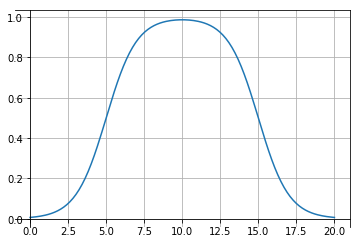

In [9]:
def f(x, x_l, x_r):
    return sigmoid(x - x_l) * sigmoid(-x + x_r)
x=np.linspace(0, 20, 200)
fig, ax = plt.subplots()
ax.plot(x, f(x, 5, 15))
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

See, what it does? It approximately maps all values in a certain bin's range to 1 and all values outside of it to 0. 
Please don't confuse this with a gaussian.

To make this function more square-looking and treat the borders appropriate, we introduce stretch and margin parameters. You'll easily figure out yourself what they do.

Here's the precise definition that we'll use in the following calucations:

Let $ x_i \in [x_{min}, x_{max}] $ be a sample from distribution $D$, $d=x_{max}-x_{min}$,
let $\alpha, \epsilon$ be arbitrary real numbers representing a stretch and a margin, then we define the *bin filter* $\beta_n(x)$ for the $n$-th bin of width $d$ as

$$ \beta_n(x_i) = \sigma(\alpha \cdot (x_i - l_n) + \epsilon) \cdot 
 \sigma(\alpha \cdot ( -x_i + l_n + d + \epsilon))
$$

Here, $l_n$ is the left border of the $n$-th bin: $l_n = x_{min} + (n-1) \cdot d$ 

In [10]:
def beta(n, N, l, r, alpha, epsilon):
    """
    return the bin function for the n-th bin of N bins for numbers between l and r
    alpha and epsilon are stretch and margin parameters
    """
    d = (r - l) / N
    l_n = l + (n-1) * d
    def _beta(x):
        sigmoid_left = tf.nn.sigmoid(alpha * (x-l_n+epsilon)) 
        sigmoid_right = tf.nn.sigmoid(alpha*(-x+l_n+d+epsilon))
        return sigmoid_left * sigmoid_right
    
    return _beta

As an example, we plot the partitioning function that maps values between $ 0.2 $ and $ 0.3 $ to the value $ 1 $ and all others to $ 0 $. Applying this function $\beta_3(x)$ to a sample produces $1$s whereever the single value in the sample is within that range, and $0$s otherwise. The sum of all the values is the number of the examples in that particular partition.

In [11]:
# hyperparameters governing the approximation
ALPHA = 1e4
EPSILON = 1e-5

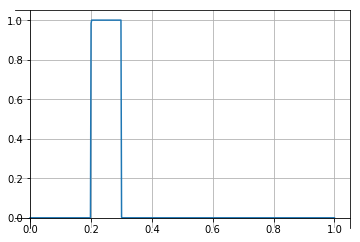

In [12]:
x=np.linspace(0, 1, 500)
fig, ax = plt.subplots()
beta3=beta(3, 10, 0, 1, alpha=ALPHA, epsilon=EPSILON)
beta3_x = sess.run(beta3(x))
ax.plot(x, beta3_x)
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

Now, let us count the number of pixels that fell between $0.2$ and $0.3$

In [13]:
# Please note that betas[0] is not used. We count the bins in a natural manner
betas = [beta(n, 10, 0, 1, alpha=ALPHA, epsilon=EPSILON) for n in range(11)]
betas[0]=None

In [14]:
sess = tf.InteractiveSession()
# The scaling (factor 0.98) and shifting by 0.01 makes sure, we don't count 0s and 1s only as halves
tf_center_all = samples[0][:, CENTER_POS] * .98 + 0.01
tf_center_all_labels = samples[1]
N_k = [tf.reduce_sum(betas[k](tf_center_all)) for k in range(1, 11)] 
sess.run(N_k)

[3760.0, 269.0, 291.0, 268.0, 260.0, 255.0, 311.0, 357.0, 372.0, 3857.0]

Please observe that those numbers are very close to the number of values that pyplot reported. 

In [15]:
sess = tf.InteractiveSession()
N_center_all = [tf.reduce_sum(betas[n](tf_center_all)) for n in range(1,11)]
calc_dist = sess.run(N_center_all)
true_dist=[3782.,  261.,  286.,  259.,  260.,  250.,  304.,  341.,  360.,3897.]
np.divide(np.subtract(calc_dist,true_dist),true_dist)*100

array([-0.5817028 ,  3.0651341 ,  1.74825175,  3.47490347,  0.        ,
        2.        ,  2.30263158,  4.69208211,  3.33333333, -1.02643059])

Computing all 10 bin counts reveals an upper bound for the error of 5%. Not bad. Let's see what we can do with it.

### 4. Computing the Entropy of a discrete distribution  

The Entropy of a distribution X was defined as

$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

Using the bin counts $c_k$ with $\sum c_k = M$ as shown above, we get

$$ H(X) = -\sum_{k=1}^N  \frac{c_k}{M} \log  \frac{c_k}{M}$$

thus using

$$ c_k = \sum_{i=1}^M \beta_k(x_i) $$

the entropy can be approximated by

$$ \tilde{H}(X) = \log M -\frac{1}{M}\sum_{k=1}^N  \sum_{i=1}^M \beta_k(x_i)  \log  \sum_{i=1}^M \beta_k(x_i) $$



In [16]:
def entropy(D, N, alpha, epsilon, squeeze=0.01):
    """
    Calculate the entropy of discrete sample D using N bins 
    """
    d_max=tf.reduce_max(D)
    d_min=tf.reduce_min(D)
    M = tf.cast(tf.size(D), dtype=tf.float32)
    D = D * (1-2*squeeze) + squeeze # otherwise min and max would be counted as halves.
    
    filters=[beta(k, N, d_min, d_max, alpha, epsilon) for k in range(1, N+1)]
    c=[tf.reduce_sum(filters[k](D)) for k in range(N)] # this is summing over i
    sums = tf.reduce_sum(c * tf.log(c)) 
    return tf.log(M) - sums / M

Note, that in the above implementation, we didn't supply lower and upper bounds so the counts may slightly differ from the previous calculations. In a scenario with a bigger range of values, that will not matter much. In the end, we know we're approximating the entropy anyway.

In [17]:
sess = tf.InteractiveSession()
sess.run(entropy(tf_center_all, 10, alpha=ALPHA, epsilon=EPSILON))

1.5702343

Now, the conditional entropy goes just the same way, only that we need to mask the classes out after counting the samples in each bin. Masking is obviously done with the help of the labels that usually come with the training samples.

Remember how we calculate the conditional entropy? In our case, $x$ is the class label - the prior - and $y$ is the index of the bin or partition that the pixel is sorted into.

$$ H(Y \big| X) = \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

The implementation is pretty straight-forward

In [18]:
def cond_entropy(D, L, N_classes, N_bins, alpha, epsilon, squeeze=1e-2):
    """
        calculate the conditional entropy of distribution D given labels L
    """
    epsilon_stab = 1e-4
    d_max=tf.reduce_max(D)
    d_min=tf.reduce_min(D)
    M=tf.cast(tf.size(D), dtype=tf.float32)
    D = D * (1-2*squeeze) + squeeze # otherwise min and max would be counted as halves.
    betas=[beta(n, N_bins, d_min, d_max, alpha, epsilon) for n in range(1, N_bins+1)]

    # The mask is used to count by class
    mask = [ tf.cast(tf.equal(c, L), tf.float32) for c in range(N_classes) ]
    # N_classes lists of counts => N_classes conditional distributions
    cond_counts = [
        [
            tf.reduce_sum(betas[n](D) * mask[k]) for n in range(N_bins)
        ] for k in range(N_classes)
    ]

    pxy = cond_counts / M # p(x,y)

    px = tf.reduce_sum(cond_counts, axis=1) / M # p(x)

    # need to transpose forth and back to enable broadcasting
    pxy_px = tf.transpose(tf.transpose(pxy) / (tf.transpose(px)) + epsilon_stab) # stabilized log term

    return -tf.reduce_sum(pxy * tf.log(pxy_px))


In [19]:
sess = tf.InteractiveSession()
D = tf_center_all
L = tf_center_all_labels
sess.run(cond_entropy(D, L, N_classes=10, N_bins=10, alpha=ALPHA, epsilon=EPSILON))

1.3081253

In [20]:
def info_gain(D, L, N_classes, N_bins, alpha, epsilon ):
    H_cond = cond_entropy(D, L, N_classes, N_bins, alpha, epsilon)
    H_D = entropy(D, N_classes, alpha, epsilon)
    return H_D - H_cond

In [21]:
sess = tf.InteractiveSession()
sess.run(info_gain(D, L, N_classes=10, N_bins=10, alpha=ALPHA, epsilon=EPSILON))

0.26210904

Now we intend to train a network to minimize the conditional entropy while maintaining the given entropy of the signal.